# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Основные шаги:
1. Загрузка данных.
2. Изучение данных. Заполнение пропусков и обработка аномалий. Удаление неинформативных признаков.
3. Подготовка выборки для обучения моделей.
4. Обучение моделей с подбором гиперпараметров.
5. Анализ времени обучения, предсказания и качества моделей.
6. Выбор лучшей модели, проверка качества на тестовой выборке.

Примечания:
- Для оценки качества моделей применяем метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.

Признаки
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

In [8]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from catboost import CatBoostRegressor
from sklearn.linear_model import ElasticNet

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

pd.options.mode.chained_assignment=None

## Подготовка данных

In [9]:
# читаем csv-файл и сохраняем в переменную df
try:
    df = pd.read_csv('/Users/sergeypervov/Downloads/autos.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv') 

df.sample(5) # смотрим случайные 5 строк из датасета для ознакомления 

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
119698,2016-03-09 11:48:21,2222,sedan,2001,manual,75,golf,150000,8,petrol,volkswagen,no,2016-03-09 00:00:00,0,38259,2016-03-10 17:16:59
114974,2016-03-10 10:25:24,7400,bus,2010,manual,102,transporter,150000,8,gasoline,volkswagen,no,2016-03-10 00:00:00,0,60598,2016-03-21 19:18:23
324824,2016-03-22 16:54:13,900,NaN,2016,NaN,101,golf,150000,3,NaN,volkswagen,NaN,2016-03-22 00:00:00,0,47798,2016-03-22 16:54:13
126565,2016-04-04 22:25:35,1,sedan,2002,auto,272,7er,5000,10,petrol,bmw,NaN,2016-04-04 00:00:00,0,65183,2016-04-05 12:30:13
268201,2016-04-03 11:59:32,5300,sedan,2005,manual,90,astra,90000,9,NaN,opel,NaN,2016-04-03 00:00:00,0,58095,2016-04-03 11:59:32


In [10]:
df.info() # смотрим информацию о датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Промежуточный вывод:** В наименованиях столбцов использован CamelCase вместо snake_case, формат данных в ячейках с датами нужно привести к datetime и уже видно, что в данных есть пропуски.

In [11]:
df.columns = df.columns.str.lower() # уберем заглавные буквы в названиях столбцов
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'repaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [12]:
df = df.rename(columns={'datecrawled': 'date_crawled', 'vehicletype': 'vehicle_type', 'registrationyear': \
'registration_year', 'registrationmonth': 'registration_month', 'fueltype': 'fuel_type', 'datecreated': \
'date_created', 'numberofpictures': 'number_of_pictures', 'postalcode': 'postal_code', 'lastseen': 'last_seen'})
df.columns   # в наименованиях из 2 слов добавим "_" между ними, чтобы улучшить читабельность, проверим результат

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [13]:
df.isna().sum() # рассмотрим пропуски поподробнее

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [14]:
columns_to_replace = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']
for column in columns_to_replace:
    df[column] = df[column].fillna('unknown')

df.isna().sum() # все пропуски в категориальных данных, поэтому заменим их на значение 'unknown'

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

In [15]:
df['date_crawled'] = pd.to_datetime(df['date_crawled'], format='%Y-%m-%dT%H:%M:%S')
df['date_created'] = pd.to_datetime(df['date_created'], format='%Y-%m-%dT%H:%M:%S')
df['last_seen'] = pd.to_datetime(df['last_seen'], format='%Y-%m-%dT%H:%M:%S')
# приведем формат данных в столбцах с датами к формату datetime

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        354369 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             354369 non-null  object        
 5   power               354369 non-null  int64         
 6   model               354369 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           354369 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            354369 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

In [16]:
df['age'] = df['date_created'].dt.year - df['registration_year'] # так как у нас объявления за разные годы, то важен именно
#возраст авто, а не конкретная дата регистрации, поэтому добавим столбец, показывающий, сколько авто полных лет на момент размещения
df.sample(5)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen,age
354093,2016-03-09 20:53:17,11390,wagon,2007,manual,232,a6,150000,11,gasoline,audi,no,2016-03-09,0,45899,2016-03-12 22:46:19,9
54291,2016-03-30 19:57:31,7700,sedan,2005,manual,179,a6,150000,4,gasoline,audi,no,2016-03-30,0,73312,2016-04-07 11:45:57,11
169602,2016-03-12 20:06:24,7700,sedan,2009,manual,80,golf,60000,4,petrol,volkswagen,no,2016-03-12,0,65614,2016-03-14 17:30:17,7
225903,2016-03-26 12:52:53,10990,small,2011,manual,105,fabia,100000,11,gasoline,skoda,no,2016-03-26,0,21279,2016-04-06 00:45:01,5
228659,2016-03-17 09:36:43,2500,unknown,2016,auto,193,clk,150000,2,unknown,mercedes_benz,no,2016-03-17,0,71686,2016-04-06 07:17:33,0


In [17]:
df.describe(include='all').T  # посмотрим укрупненно на статистики данных

/var/folders/8y/6qgr48pn4js29rkc2ts9hck80000gn/T/ipykernel_13926/2087345762.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all').T  # посмотрим укрупненно на статистики данных
/var/folders/8y/6qgr48pn4js29rkc2ts9hck80000gn/T/ipykernel_13926/2087345762.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all').T  # посмотрим укрупненно на статистики данных
/var/folders/8y/6qgr48pn4js29rkc2ts9hck80000gn/T/ipykernel_13926/2087345762.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and wi

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
date_crawled,354369,271174,2016-03-24 14:49:47,7,2016-03-05 14:06:22,2016-04-07 14:36:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,354369.0,NaN,NaN,NaN,NaT,NaT,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
vehicle_type,354369,9,sedan,91457,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
registration_year,354369.0,NaN,NaN,NaN,NaT,NaT,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
gearbox,354369,3,manual,268251,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
power,354369.0,NaN,NaN,NaN,NaT,NaT,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
model,354369,251,golf,29232,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kilometer,354369.0,NaN,NaN,NaN,NaT,NaT,128211.172535,37905.34153,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,354369.0,NaN,NaN,NaN,NaT,NaT,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
fuel_type,354369,8,petrol,216352,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Промежуточный вывод:** У нас данные об объявлениях за 2 года (с матра 2014 по апрель 2016). В ценах есть аномальное значение "0", подробнее рассмотрим далее. В годе регистрации есть аномалии, как в меньшую, так и в большую стороны: минимальное значение - 1000й год, максимальное - 9999й, подробнее рассмотрим далее. С мощностью двигателя тоже явно есть аномалии , так как мин. знаяение "0", а макс. - "20000" л.с. при том, что даже суперкары в основном имеют мощность 1600 л.с., изредка до 5000 л.с., подробнее рассмотрим далее. Похоже, что столбец с количеством фотографий неинформативен, так как имеет одни нулевые значения, проверим это далее. В почтовых индексах есть 4-значные коды, чего не бывает в РФ, возможно это только первые цифры кода, попробуем разобраться далее. Чтобы корректнее оценить возраст авто, нужно сначала избавиться от аномалий в данных о годе регистрации.

In [18]:
df['number_of_pictures'].value_counts() # перепроверим гипотезу о нулевых значениях в столбце с фотографиями

0    354369
Name: number_of_pictures, dtype: int64

In [19]:
df = df.drop(['number_of_pictures'] , axis=1).copy() # так и есть, можно удалить данный столбец, как неинформативный
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        354369 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             354369 non-null  object        
 5   power               354369 non-null  int64         
 6   model               354369 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           354369 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            354369 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  postal_code         354369 no

In [20]:
df.drop(['postal_code'] , axis=1).corr() # посмотрим на корреляции между числовыми значениями, дропаем индекс, так как он
# по сути категориальный, а не числовой

,price,registration_year,power,kilometer,registration_month,age
price,1.000000,0.026916,0.158872,-0.333199,0.110581,-0.026917
registration_year,0.026916,1.000000,-0.000828,-0.053447,-0.011619,-1.000000
power,0.158872,-0.000828,1.000000,0.024002,0.043380,0.000828
kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,0.053447
registration_month,0.110581,-0.011619,0.043380,0.009571,1.000000,0.011619
age,-0.026917,-1.000000,0.000828,0.053447,0.011619,1.000000


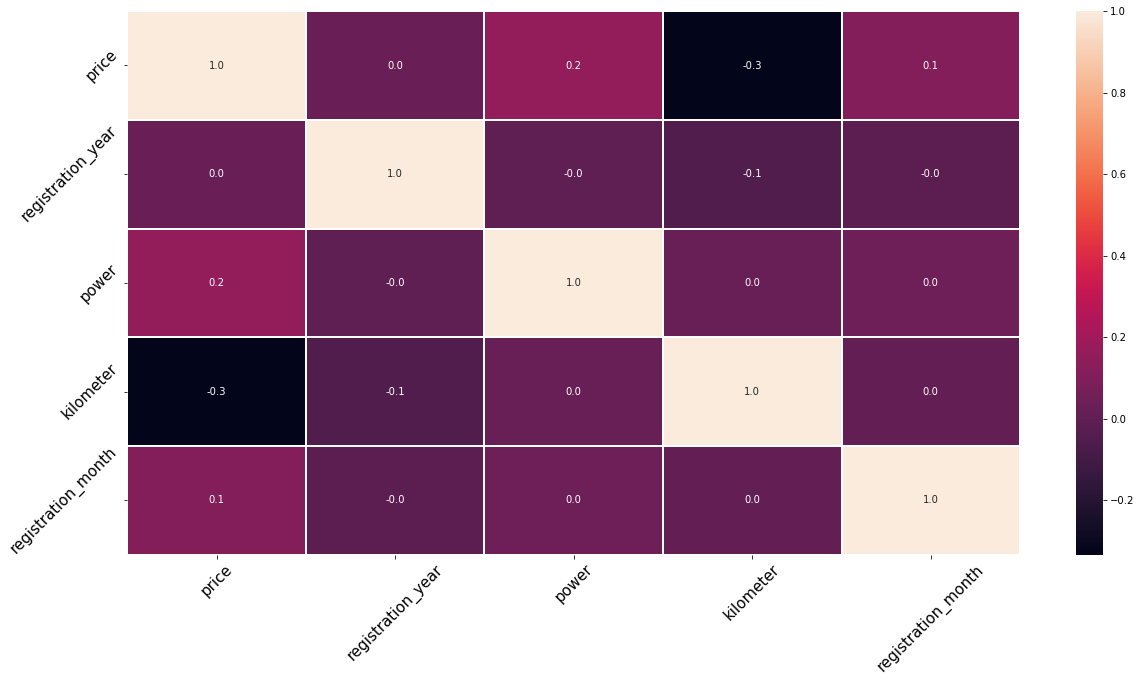

In [21]:
plt.figure(figsize=(20,10)) # визуализируем в виде хитмэпа, но уже без возраста, чтобы не отвлекаться на корр. с годом рег-и
ax = sns.heatmap(df.drop(['postal_code', 'age'] , axis=1).corr(), annot=True, fmt=".1f", linewidths=.01)
ax.tick_params(rotation=45, labelsize=15);

**Промежуточный вывод:** Возраст коррелирует с годом регистрации авто по понятным причинам, но в фичах будет только один из этих признаков. В остальном, высоких значений корреляии между фичами нет, так что беспокоиться о рисках мультиколлинеарности для линейных моделей не приходится. Таргет же также не имеет ощутимых линейных связей с фичами, что не так хорошо для тех же линейных моделей. Месяц регистрации имеет немного более высокое значение корреляции, чем год. Связано это с тем, что, чем больше значение месяца, тем позже в году авто зарегистрировано, а значит, тем оно моложе, однако месяцев всего 12 вариантов и вес каждого получается больше, по сравнению с годами. Я бы оставил среди фичей только возраст авто, который заменит собой оба столбца, связанных с датой регистрации. В целом же из числовых фичей с таргетом сильнее всего коррелирует пробег (корреляция отрицательная, так как, чем больше пробег, тем ниже цена).

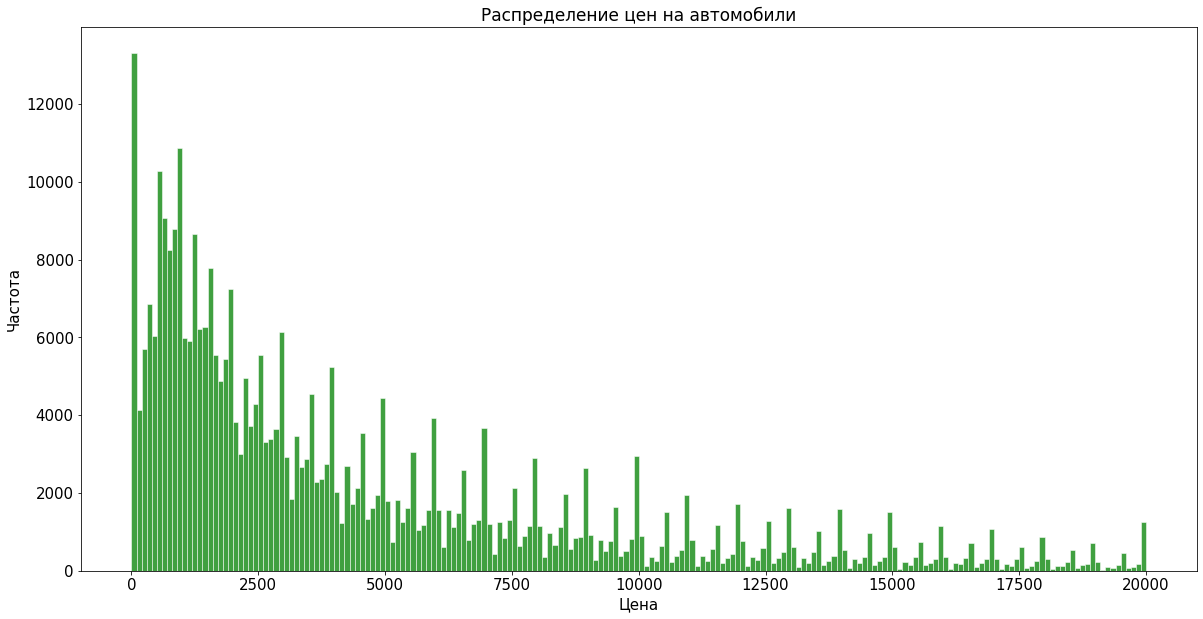

In [23]:
plt.figure(figsize=(20, 10)) # рассмотрим поподробнее распределение цен
ax = sns.histplot(data=df, x='price', binwidth=100, color='green', edgecolor='white')
ax.set_title('Распределение цен на автомобили', fontsize=17)
ax.set_xlabel('Цена',fontsize=15)
ax.set_ylabel('Частота',fontsize=15)
ax.tick_params(labelsize=15);

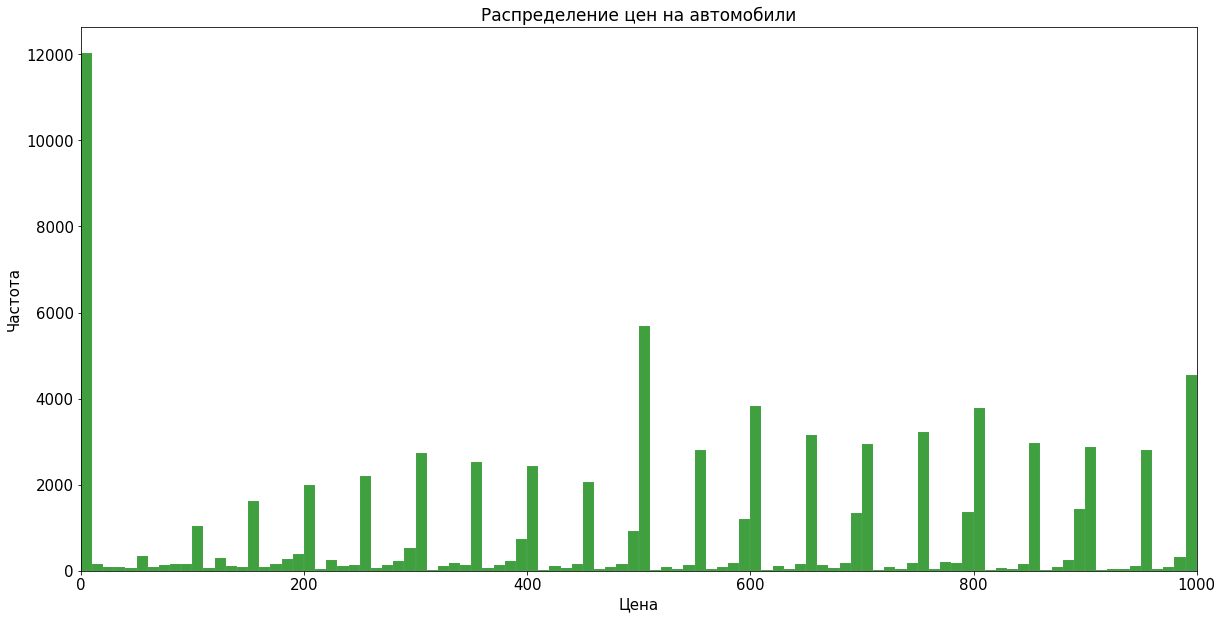

In [24]:
plt.figure(figsize=(20, 10))
ax = sns.histplot(data=df, x='price', binwidth=10, color='green', edgecolor='white')
ax.set_xlim(0,1000)
ax.set_title('Распределение цен на автомобили', fontsize=17)
ax.set_xlabel('Цена',fontsize=15)
ax.set_ylabel('Частота',fontsize=15)
ax.tick_params(labelsize=15);

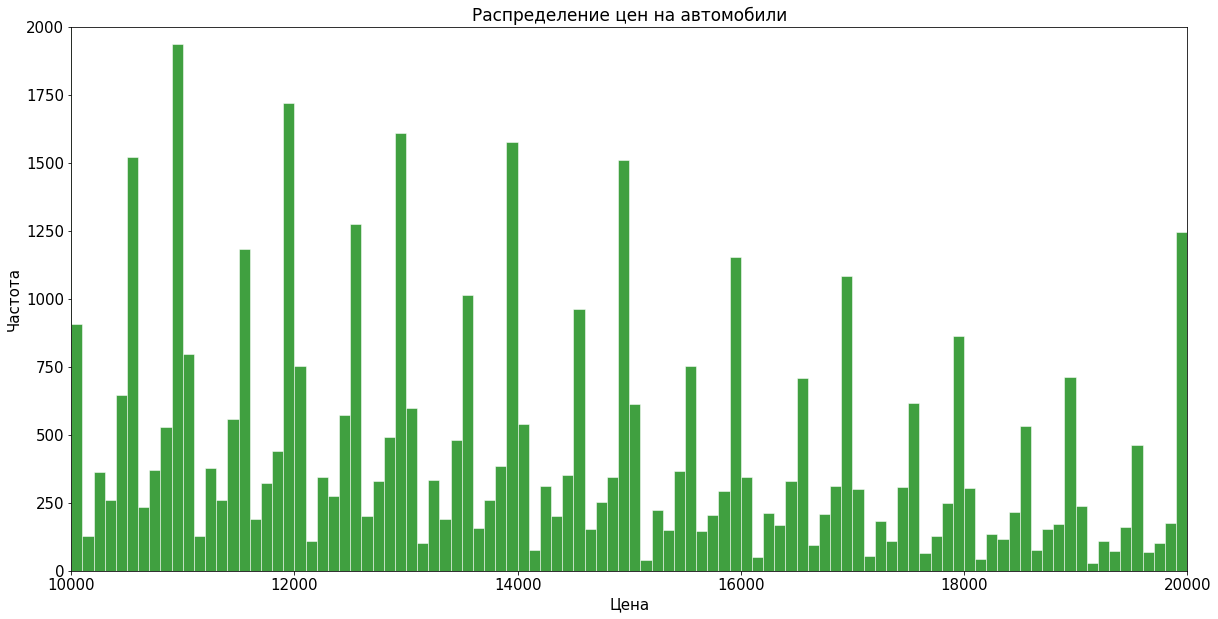

In [26]:
plt.figure(figsize=(20, 10))
ax = sns.histplot(data=df, x='price', binwidth=100, color='green', edgecolor='white')
ax.set_xlim(10000,20000)
ax.set_ylim(0,2000)
ax.set_title('Распределение цен на автомобили', fontsize=17)
ax.set_xlabel('Цена',fontsize=15)
ax.set_ylabel('Частота',fontsize=15)
ax.tick_params(labelsize=15);

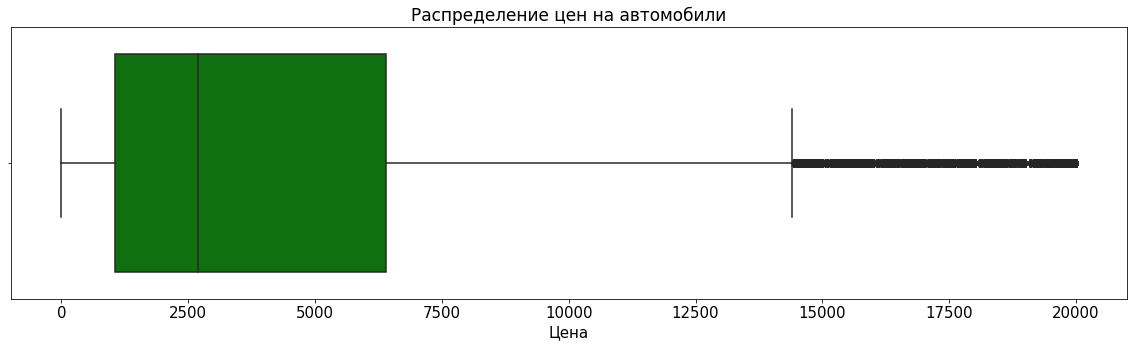

In [27]:
# посмотрим также ящик с усами
plt.figure(figsize=(20,5))
#plt.xlim(0, 1000)
ax = sns.boxplot(x='price', data=df, orient="h", color='green')
ax.set_title('Распределение цен на автомобили', fontsize=17)
ax.set_xlabel('Цена',fontsize=15)
ax.tick_params(labelsize=15);

In [28]:
df[df['price'] == 0].shape #посмотрим, сколько всего объявлений в датасете с бесплатными авто

(10772, 16)

**Промежуточный вывод:** Хоть ящик с усами и показывает цены свыше примерно 14000 и до 20000 евро, как потенциальные выбросы, тем не менее - это вполне реальные цены, пусть и не с самой высокой частотностью, а вот значимое кол-во объявлений с нулевой стоимостью - точно аномалия, которую следует удалить из датасета до обучения модели. 

In [29]:
df['vehicle_type'].sort_values().unique() # посмотрим, нет ли неявных дубликатов среди уникальных типов кузова

array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'unknown', 'wagon'], dtype=object)

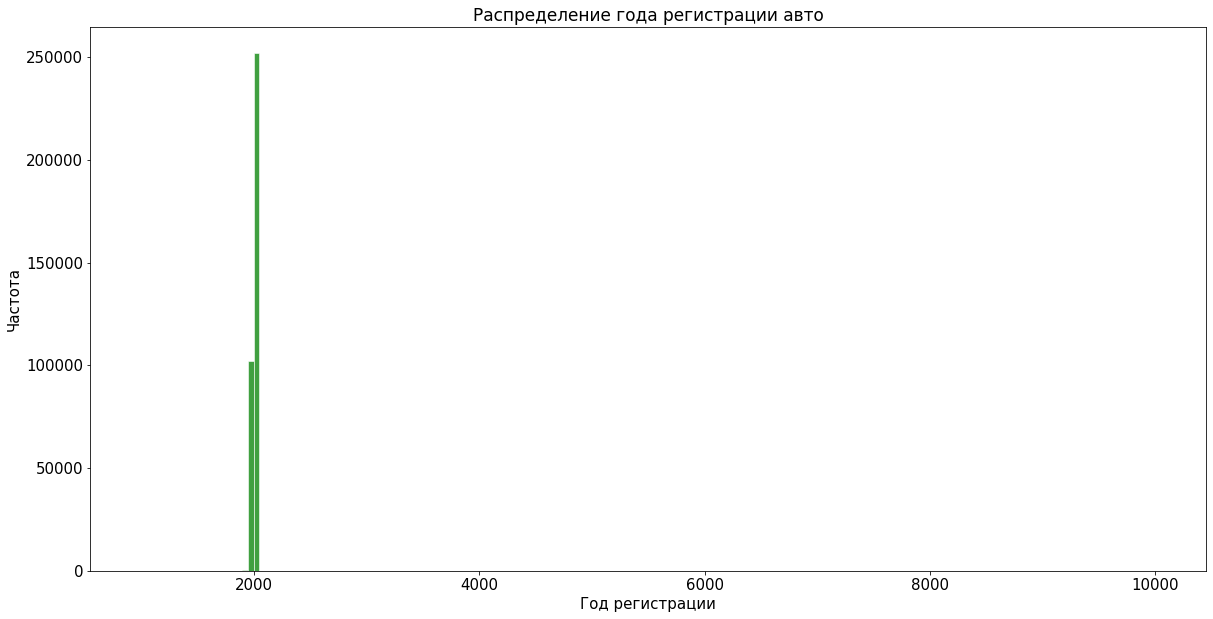

In [30]:
# рассмотрим поподробнее распределение значений года регистрации авто

plt.figure(figsize=(20, 10))
ax = sns.histplot(data=df, x='registration_year', binwidth=50, color='green', edgecolor='white')
ax.set_title('Распределение года регистрации авто', fontsize=17)
ax.set_xlabel('Год регистрации',fontsize=15)
ax.set_ylabel('Частота',fontsize=15)
ax.tick_params(labelsize=15);

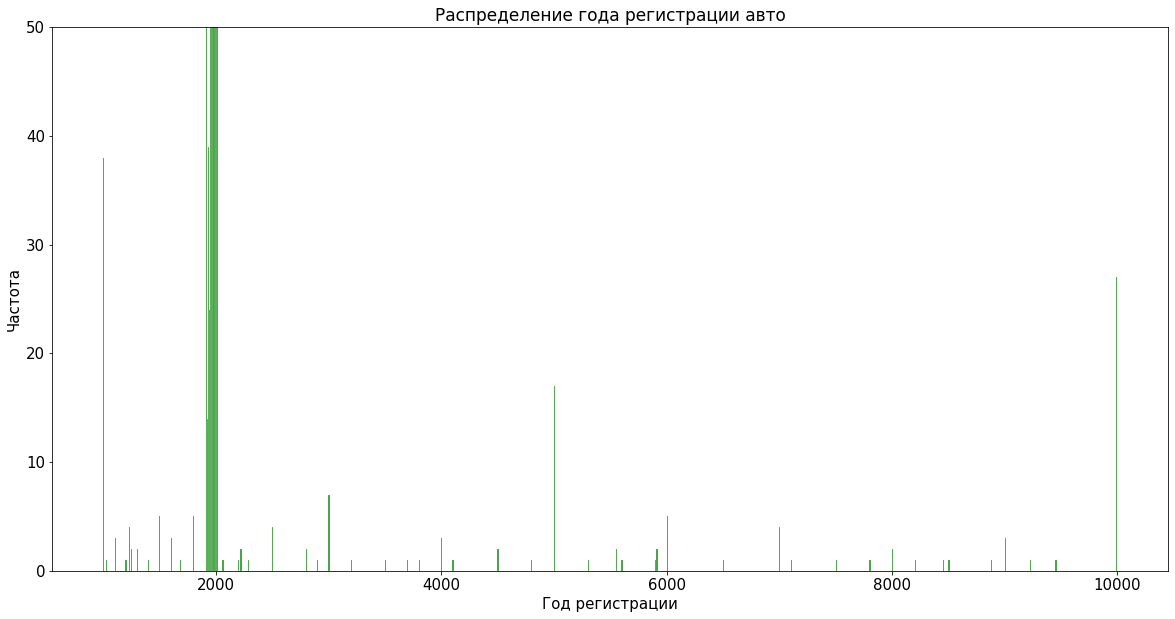

In [31]:
plt.figure(figsize=(20, 10))
ax = sns.histplot(data=df, x='registration_year', binwidth=10, color='green', edgecolor='white')
ax.set_ylim(0,50)
ax.set_title('Распределение года регистрации авто', fontsize=17)
ax.set_xlabel('Год регистрации',fontsize=15)
ax.set_ylabel('Частота',fontsize=15)
ax.tick_params(labelsize=15);

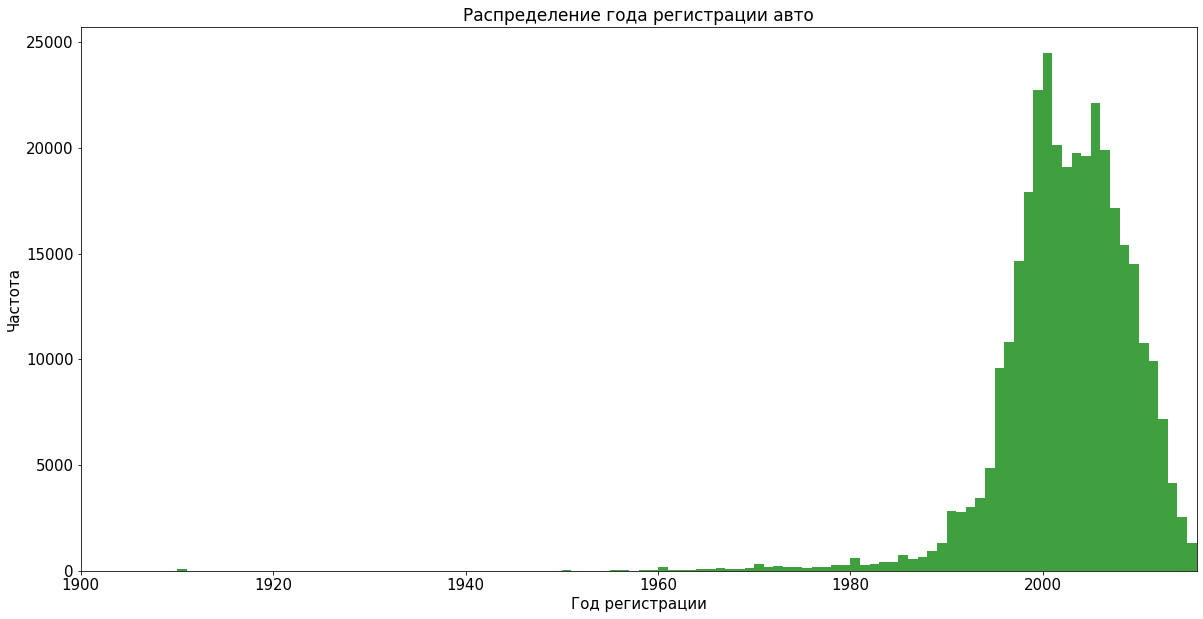

In [32]:
plt.figure(figsize=(20, 10))
ax = sns.histplot(data=df, x='registration_year', binwidth=1, color='green', edgecolor='white')
ax.set_xlim(1900,2016) # так как у нас самые поздние объявления 2016 года, то это максимальный возможный год регистрации авто
#ax.set_ylim(0,500)
ax.set_title('Распределение года регистрации авто', fontsize=17)
ax.set_xlabel('Год регистрации',fontsize=15)
ax.set_ylabel('Частота',fontsize=15)
ax.tick_params(labelsize=15);

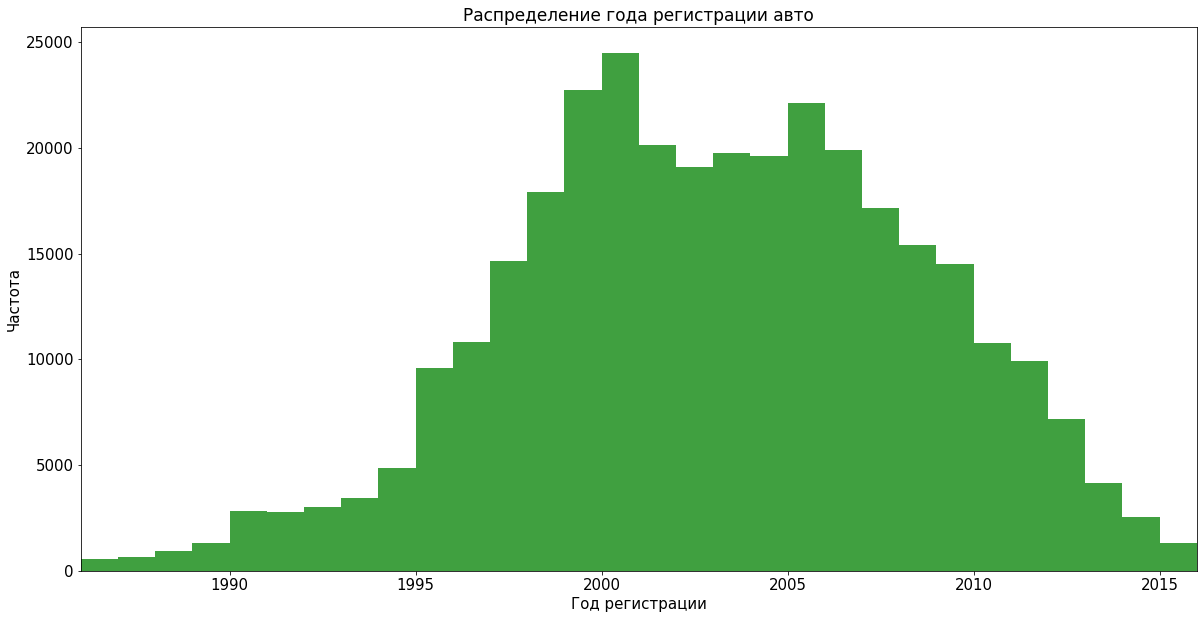

In [33]:
plt.figure(figsize=(20, 10))
ax = sns.histplot(data=df, x='registration_year', binwidth=1, color='green', edgecolor='white')
ax.set_xlim(1986,2016) # до 1980 частотность совсем низкая, а лучше еще сильнее ограничить возраст авто, пожалуй 30лет, как
# максимум будет более, чем достаточно (1986 - 2016)
#ax.set_ylim(0,500)
ax.set_title('Распределение года регистрации авто', fontsize=17)
ax.set_xlabel('Год регистрации',fontsize=15)
ax.set_ylabel('Частота',fontsize=15)
ax.tick_params(labelsize=15);

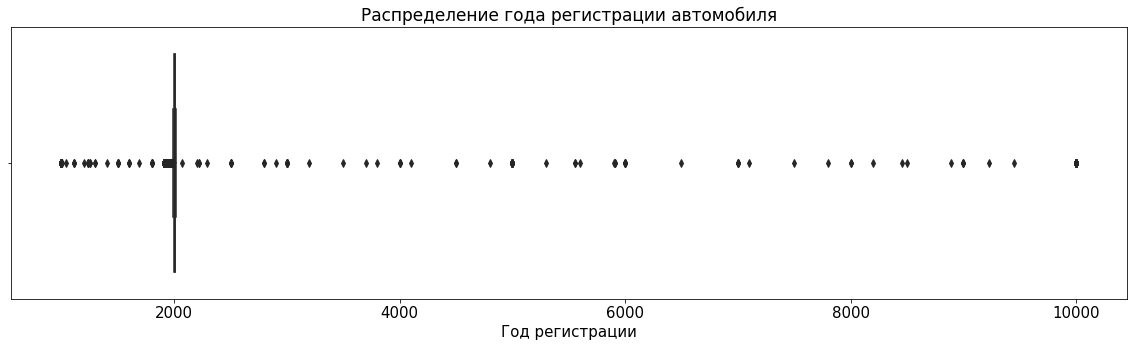

In [34]:
plt.figure(figsize=(20,5)) # посмотрим также ящик с усами
#plt.xlim(0, 1000);
ax = sns.boxplot(x='registration_year', data=df, orient="h", color='green')
ax.set_title('Распределение года регистрации автомобиля', fontsize=17)
ax.set_xlabel('Год регистрации',fontsize=15)
ax.tick_params(labelsize=15);

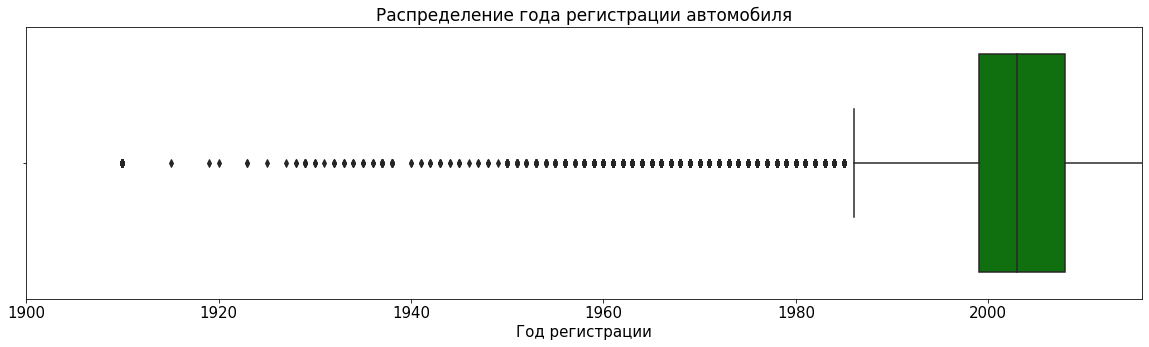

In [35]:
plt.figure(figsize=(20,5)) 
plt.xlim(1900, 2016)
ax = sns.boxplot(x='registration_year', data=df, orient="h", color='green')
ax.set_title('Распределение года регистрации автомобиля', fontsize=17)
ax.set_xlabel('Год регистрации',fontsize=15)
ax.tick_params(labelsize=15);

**Промежуточный вывод:** Аномальные значения года регистрации после 2016 года следует удалить, как и те, что до 1900, а если еще брать во внимание низкую частоту значений до 1980-1985 включительно и нахождение в зоне выбросов на ящике с усами, плюс подключить здравый смысл и ограничить возраст авто хотя бы 30 годами, то лучше отбросить данные до 1986 года.

In [36]:
df['gearbox'].sort_values().unique() # смотрим значения КПП на предмет неявных дубликатов

array(['auto', 'manual', 'unknown'], dtype=object)

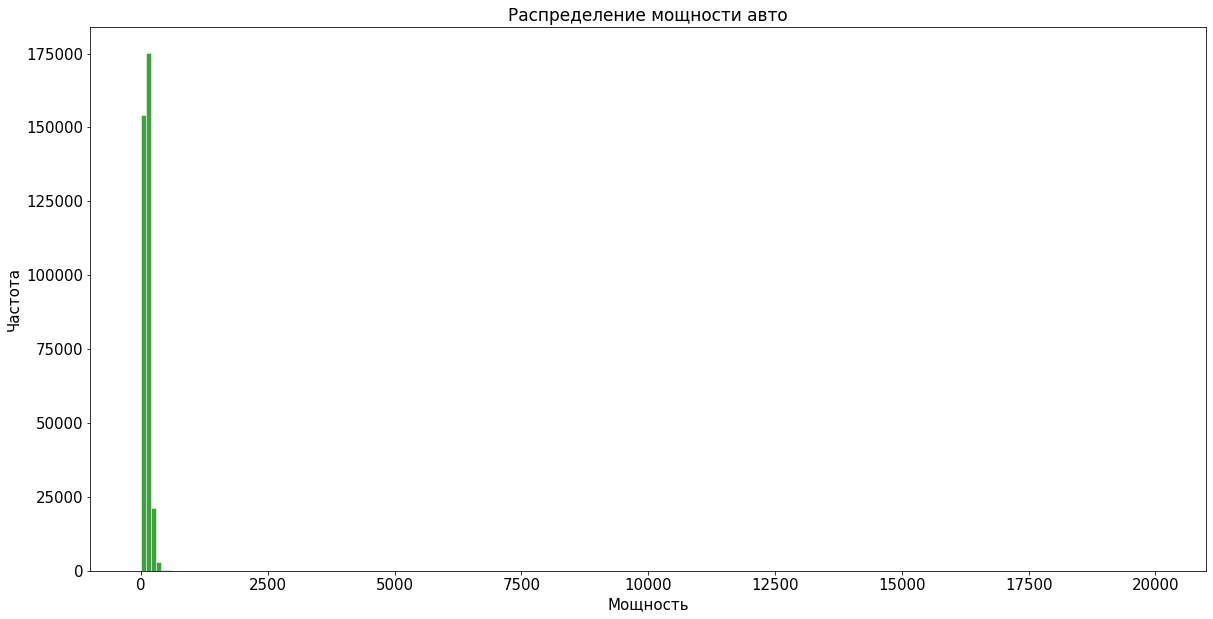

In [37]:
# посмотрим распределение мощности двигателей в л.с.

plt.figure(figsize=(20, 10))
ax = sns.histplot(data=df, x='power', binwidth=100, color='green', edgecolor='white')
#ax.set_xlim(0,240)
#ax.set_ylim(0,1000)
ax.set_title('Распределение мощности авто', fontsize=17)
ax.set_xlabel('Мощность',fontsize=15)
ax.set_ylabel('Частота',fontsize=15)
ax.tick_params(labelsize=15);

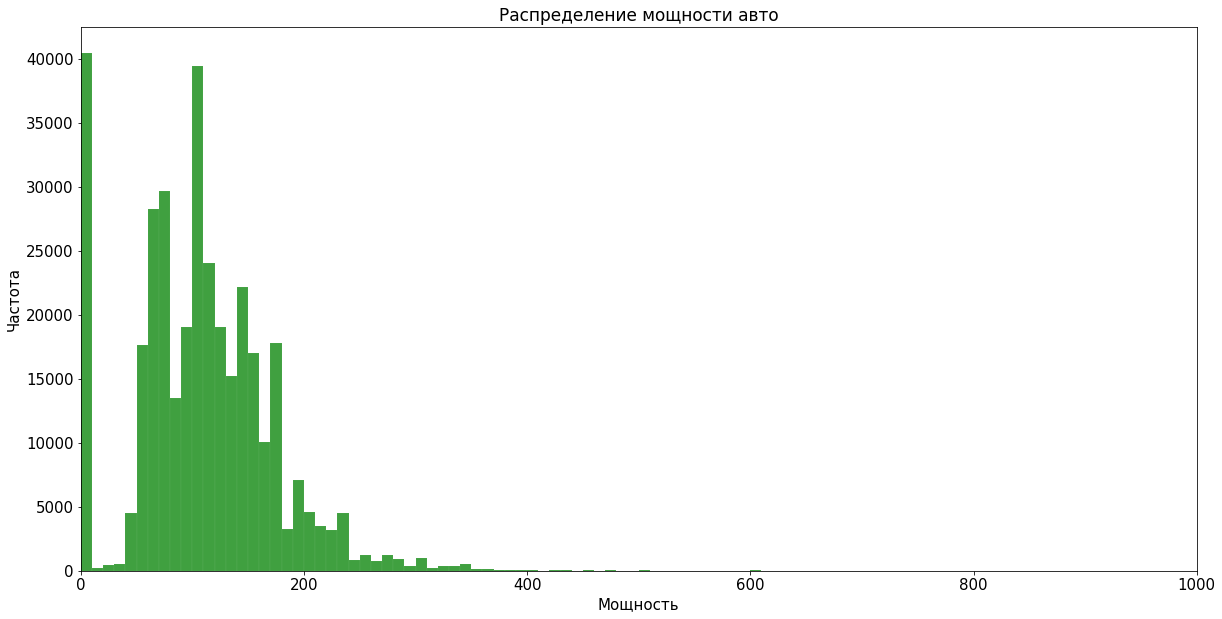

In [38]:
plt.figure(figsize=(20, 10))
ax = sns.histplot(data=df, x='power', binwidth=10, color='green', edgecolor='white')
ax.set_xlim(0,1000)
#ax.set_ylim(0,1000)
ax.set_title('Распределение мощности авто', fontsize=17)
ax.set_xlabel('Мощность',fontsize=15)
ax.set_ylabel('Частота',fontsize=15)
ax.tick_params(labelsize=15);

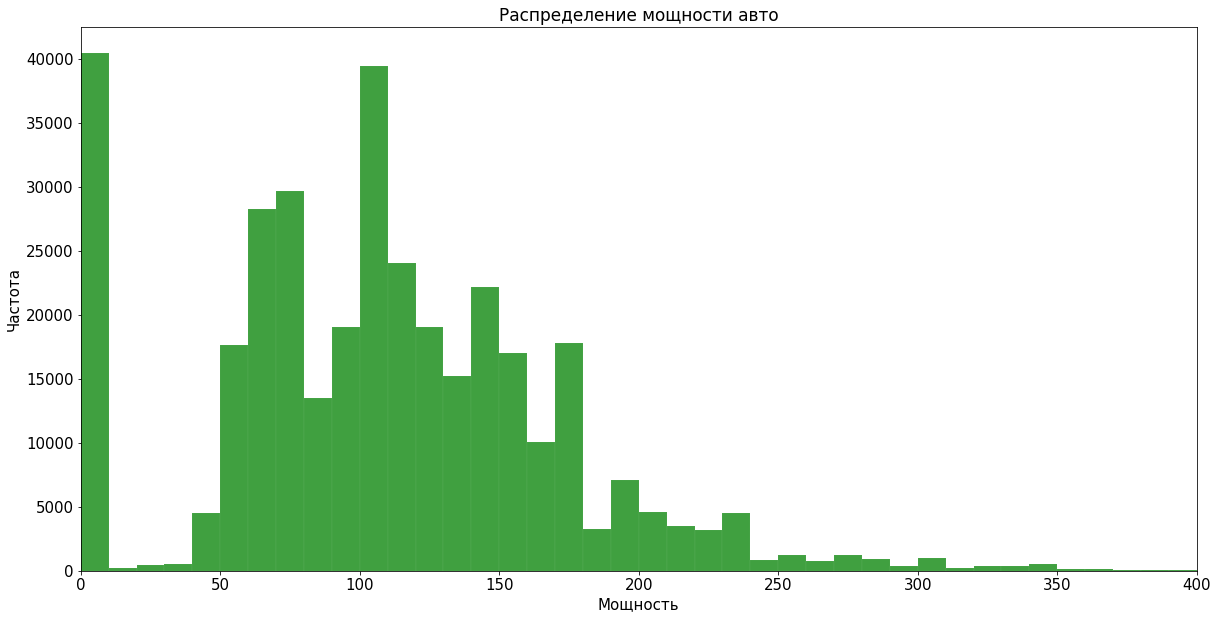

In [39]:
plt.figure(figsize=(20, 10))
ax = sns.histplot(data=df, x='power', binwidth=10, color='green', edgecolor='white')
ax.set_xlim(0,400)
#ax.set_ylim(0,1000)
ax.set_title('Распределение мощности авто', fontsize=17)
ax.set_xlabel('Мощность',fontsize=15)
ax.set_ylabel('Частота',fontsize=15)
ax.tick_params(labelsize=15);

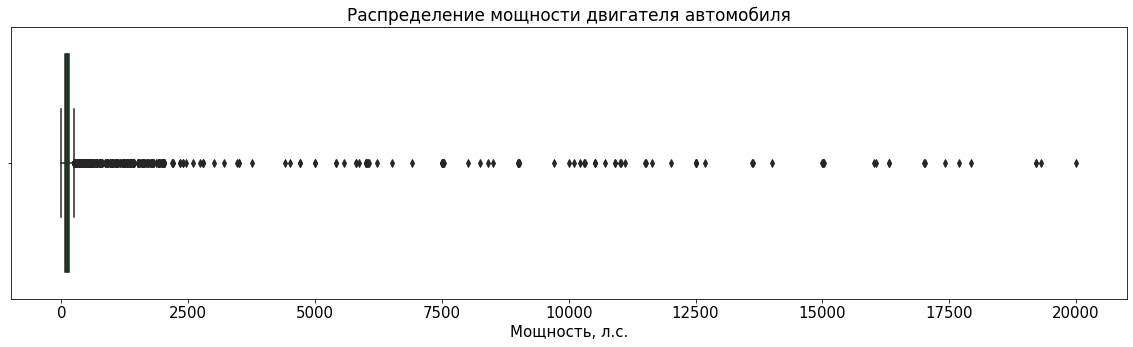

In [40]:
plt.figure(figsize=(20,5)) # посмотрим также ящик с усами
#plt.xlim(1900, 2016)
ax = sns.boxplot(x='power', data=df, orient="h", color='green')
ax.set_title('Распределение мощности двигателя автомобиля', fontsize=17)
ax.set_xlabel('Мощность, л.с.',fontsize=15)
ax.tick_params(labelsize=15);

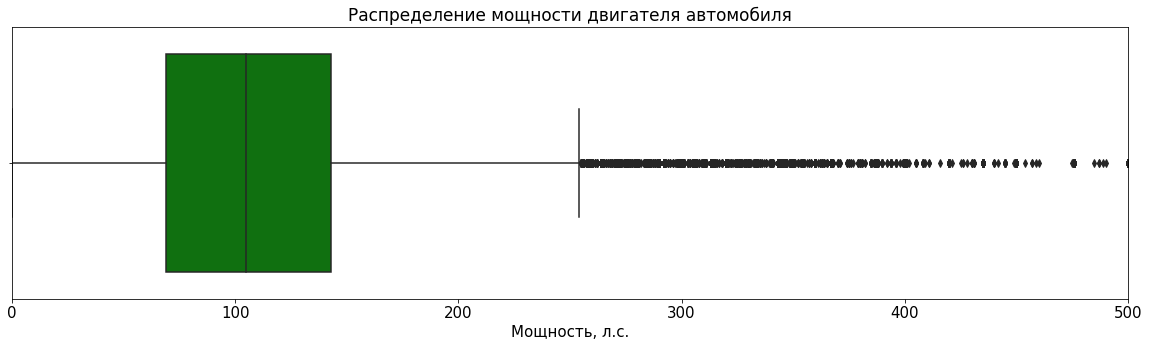

In [41]:
plt.figure(figsize=(20,5))
plt.xlim(0, 500)
ax = sns.boxplot(x='power', data=df, orient="h", color='green')
ax.set_title('Распределение мощности двигателя автомобиля', fontsize=17)
ax.set_xlabel('Мощность, л.с.',fontsize=15)
ax.tick_params(labelsize=15);

**Промежуточный вывод:** Аномалию в виде нулевого значения мощности нужно удалять из данных для обучения, да и до 40 и после 310 л.с. частота сильно падает, имеет смысл это также учесть, не говоря уже об аномалиях свыше 1600-5000 л.с. 

In [42]:
df['model'].sort_values().unique() # проверим модели авто на предмет скрытых дубликатов

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

In [43]:
df['model'] = df['model'].replace('rangerover', 'range_rover') # убираем неявные дубликаты
df['model'].sort_values().unique() # проверим результат

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

In [44]:
df['fuel_type'].sort_values().unique() # проверим тип топлива на предмет скрытых дубликатов

array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol',
       'unknown'], dtype=object)

In [45]:
df['fuel_type'] = df['fuel_type'].replace('petrol', 'gasoline') #убираем неявные дубликаты(gasoline и petrol-это синонимы)
df['fuel_type'].sort_values().unique() # проверим результат

array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'unknown'],
      dtype=object)

In [46]:
df['brand'].sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

In [47]:
df[df['brand'] == 'rover'].model.unique() # проверим, имеется ввиду Land Rover или иной производитель по моделям

array(['other', 'discovery', 'unknown', 'range_rover', 'freelander',
       'defender'], dtype=object)

In [48]:
df['brand'] = df['brand'].replace('rover', 'land_rover') # убираем неявные дубликаты
df['brand'].sort_values().unique() # проверим результат

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

In [49]:
df['repaired'].value_counts() 

no         247161
unknown     71154
yes         36054
Name: repaired, dtype: int64

In [50]:
df['postal_code'].value_counts()   #.head(1000)

10115    819
65428    613
66333    343
32257    317
44145    317
        ... 
91801      1
31097      1
82444      1
94359      1
31096      1
Name: postal_code, Length: 8143, dtype: int64

In [51]:
df[df['postal_code'] <= 9999].shape

(18159, 16)

In [52]:
six = df[df['postal_code'] > 9999]
text = six.postal_code.astype(str)
#code = text.str.extract(r'(\d{1,3})')
code = text.str[:3]
code.value_counts().head(500)

904    2095
458    1849
603    1595
381    1481
266    1452
       ... 
536     302
973     300
851     291
395     290
815     289
Name: postal_code, Length: 500, dtype: int64

**Промежуточный вывод:** Было бы здорово увязать почтовые индексы по первым 3 цифрам с регионами, чтобы более укрупненно категоризировать данные, однако из 5 топовых по упоминаниям первых 3 цифр индексов только один соответствует реальному почтовому индексу РФ, остальные 4 не встречаются, возможно индексы не относятся к РФ, это могло бы объяснить и встречающиеся 4-значные индексы. Тем не менее, идентификация с конкретными регионами затруднена, индексы не совпадают с реальными. В такой ситуации будет спокойнее не использовать данный столбец при обучении модели, хоть и жаль, что не получится дифференцировать ценообразование в зависимости от региона. 

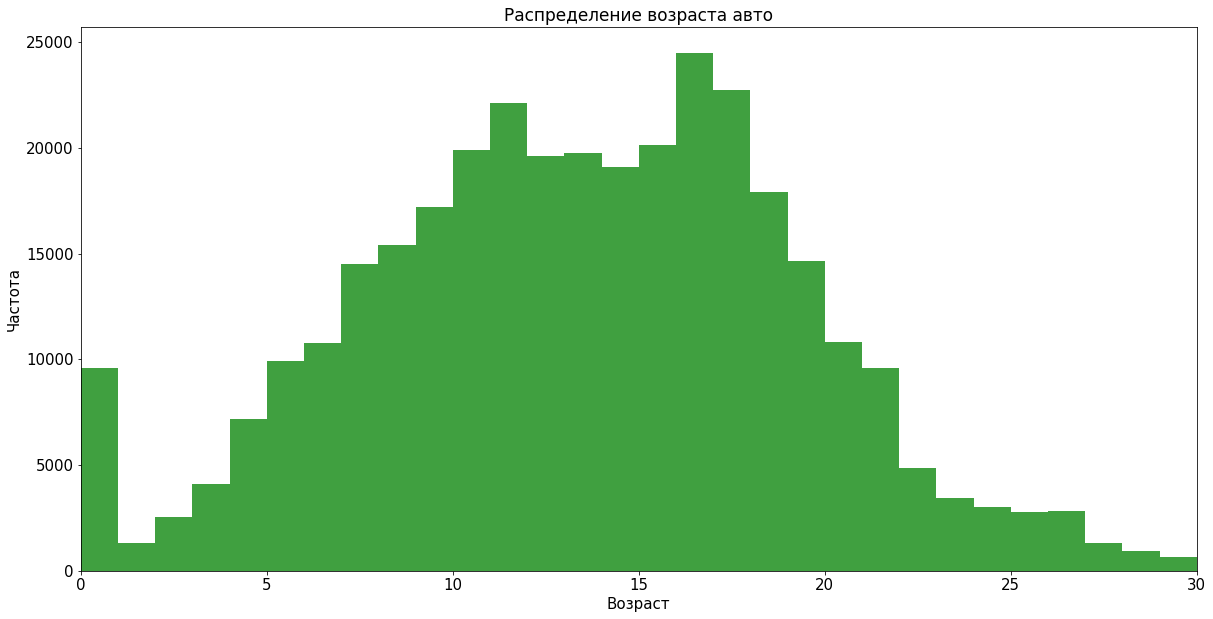

In [53]:
# посмотрим подробнее распределение возраста авто (заранее ограничив влияние аномалий даты регистрации)
# в данном случае нулевые значения не аномалия, а машины моложе года
plt.figure(figsize=(20, 10))
ax = sns.histplot(data=df, x='age', binwidth=1, color='green', edgecolor='white')
ax.set_xlim(0,30)
#ax.set_ylim(0,1000)
ax.set_title('Распределение возраста авто', fontsize=17)
ax.set_xlabel('Возраст',fontsize=15)
ax.set_ylabel('Частота',fontsize=15)
ax.tick_params(labelsize=15);

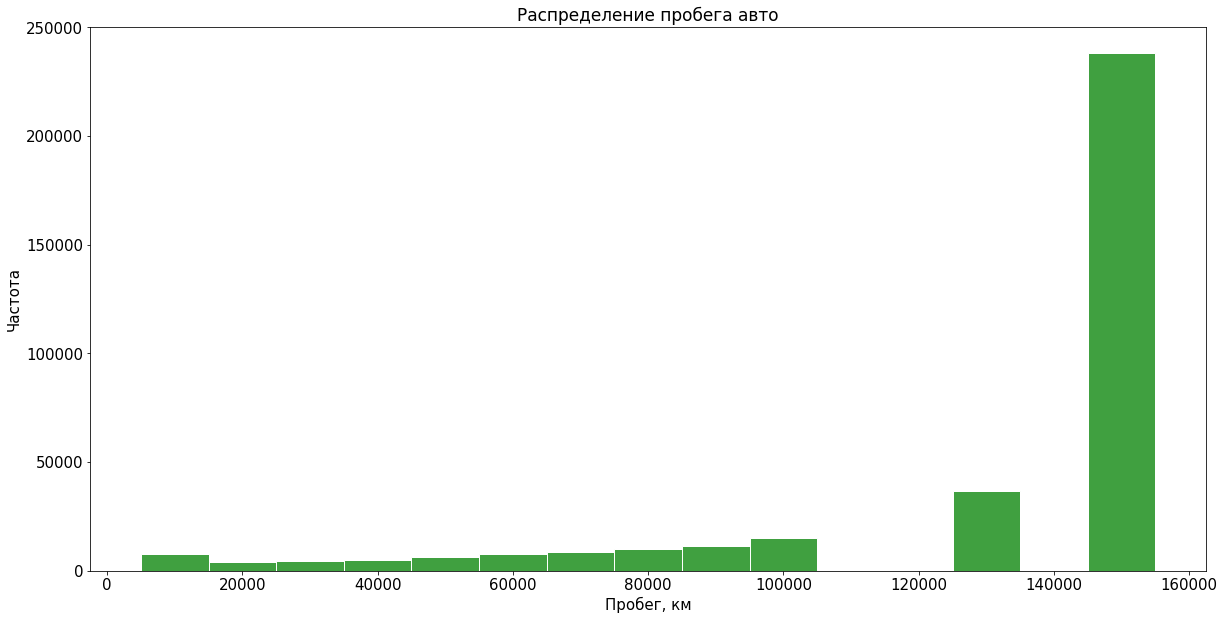

In [54]:
# посмотрим подробнее распределение пробега авто
plt.figure(figsize=(20, 10))
ax = sns.histplot(data=df, x='kilometer', binwidth=10000, color='green', edgecolor='white')
ax.set_title('Распределение пробега авто', fontsize=17)
ax.set_xlabel('Пробег, км',fontsize=15)
ax.set_ylabel('Частота',fontsize=15)
ax.tick_params(labelsize=15);

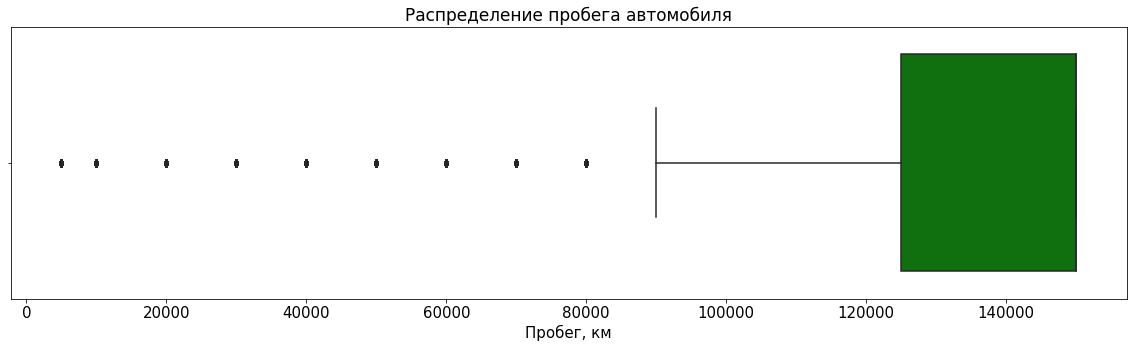

In [55]:
plt.figure(figsize=(20,5))
#plt.xlim(0, 500)
ax = sns.boxplot(x='kilometer', data=df, orient="h", color='green')
ax.set_title('Распределение пробега автомобиля', fontsize=17)
ax.set_xlabel('Пробег, км',fontsize=15)
ax.tick_params(labelsize=15);

**Промежуточный вывод:** Немного неожиданное распределение пробегов: мало частот по небольшим и средним пробегам, хотя зачастую люди стараются продать авто до истечения срока гарантии и при только городском использовании пробеги не должны быть большими, однако нет причин не доверять статистике по конкретной выборке.

In [56]:
df.duplicated().sum()

4

**Промежуточный вывод:** Учитывая, что в датасете нет уникальных номеров объявлений и его размеры, то такое кол-во дубликатов вполне допустимо теоретически. 

In [57]:
# итак, перед обучением моделей очистим датасет от выявленных аномалий

df = df[(df['price'] > 0) & (df['registration_year'] >= 1986) & (df['registration_year'] <= 2016) & \
(df['power'] >= 40) & (df['power'] <= 310)].copy()
df.shape

(289620, 16)

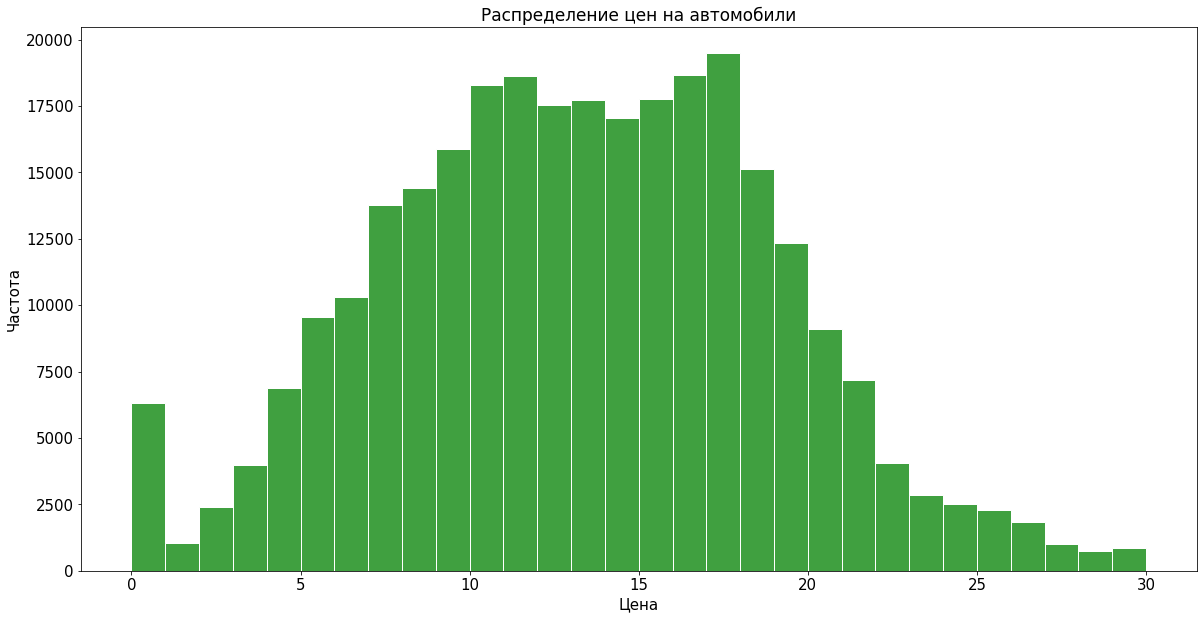

In [58]:
plt.figure(figsize=(20, 10)) # перепроверим распределение возраста авто, не появилось ли отрицательных значений (если объявление
ax = sns.histplot(data=df, x='age', binwidth=1, color='green', edgecolor='white') # 2014 или 2015, а регистрация позже)
ax.set_title('Распределение цен на автомобили', fontsize=17)
ax.set_xlabel('Цена',fontsize=15)
ax.set_ylabel('Частота',fontsize=15)
ax.tick_params(labelsize=15);

**Вывод:** Изначальная длина датасета 354369 строк. Пропуски были только в категориальных переменных, заполнили их значением "unknown". Заменили CamelCase в наименованиях столбцов на snake_case. Удалили неинформативный столбец с колияеством фото, так как он весь состоял из нулевых значений. Перед обучением убрали из датасета такие аномалии и выбросы, как нулевая цена, дата регистрации авто до 1986 и после 2016гг, мощность двигателя меньше 40 и свыше 310 л.с. После удаления аномалий и выбросов длина датасета сократилась до 289620 строк. Добавили новый столбец с возрастом авто, который заменит собой столбцы с годом и месяцем регистрации при обучении модели. Приняли решение об удалении столбца с почтовыми индексами при обучении, так как нет возможности увязать его с конкретными локациями - большая часть самых ходовых индексов не существует в РФ, а если относится к другой стране, то нет возможности идентифицировать, к какоц именно. Также при обучении будем удалять столбцы с датами: получения данных (не связано с объявлением), создания объявления (заменено на возраст авто), последнего дня объявления (можно бы было также изучить зависимость длительности экспозиции объявления от цены, однако нет гарантий, что объявление в 100% случаев убирали с площадки сразу после продажи, да и задача в проекте стоит другая).

## Обучение моделей

In [59]:
df = df.drop(['date_crawled', 'registration_year', 'registration_month', 'date_created', 'postal_code', 'last_seen'] \
             , axis=1).copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289620 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   price         289620 non-null  int64 
 1   vehicle_type  289620 non-null  object
 2   gearbox       289620 non-null  object
 3   power         289620 non-null  int64 
 4   model         289620 non-null  object
 5   kilometer     289620 non-null  int64 
 6   fuel_type     289620 non-null  object
 7   brand         289620 non-null  object
 8   repaired      289620 non-null  object
 9   age           289620 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 24.3+ MB


**Промежуточный вывод:** Удалили 6 неинформативных или продублированных столбцов перед обучением.

In [60]:
RS = 12345
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
#num_features = ['power', 'kilometer', 'age']

### CatBoostRegressor

In [61]:
features_cbr = df.drop(['price'], axis=1)
target_cbr = df['price']

In [62]:
# у нас ситуация, когда есть исходные данные и нужно их поделить на 3 выборки: делим в соотношении 3:1:1 (60%, 20%, 20%). 
# Метод train_test_split не дает возможности сразу разделить данные на 3 части, поэтому применяем его 2 раза последовательно:
features_train_valid_cbr, features_test_cbr, target_train_valid_cbr, target_test_cbr = train_test_split(
    features_cbr, target_cbr, test_size=0.2, random_state=RS) # отделяем 20% данных для тестовой выборки
features_train_cbr, features_valid_cbr, target_train_cbr, target_valid_cbr = train_test_split(
    features_train_valid_cbr, target_train_valid_cbr, test_size=0.25, random_state=RS) # отделяем 20% (25% от оставшихся) 
                                                                                  # данных для валидационной выборки

In [63]:
best_cbr_model = None
best_cbr_rmse = 10000
best_cbr_it = 0
best_cbr_depth = 0
best_cbr_lr = 0
for it in range(10, 51, 20):
    for depth in range(1, 6, 2):
        for lr in np.arange(0.2, 0.9, 0.3):
            model_cbr = CatBoostRegressor(loss_function='RMSE', iterations=it, learning_rate=lr, depth=depth, \
                                          random_seed=RS, verbose=10)
            model_cbr.fit(features_train_cbr, target_train_cbr, cat_features=cat_features) # обучаем модель на тренировочной выборке
            pred_valid_cbr = model_cbr.predict(features_valid_cbr) 
            rmse_cbr = mean_squared_error(target_valid_cbr, pred_valid_cbr, squared=False) # считаем качество модели на валидационной выборке
            if rmse_cbr < best_cbr_rmse:
                best_cbr_model = model_cbr # сохраняем наилучшую модель
                best_cbr_rmse = rmse_cbr #  сохраняем наилучшее значение метрики rmse на валидационных данных
                best_cbr_it = it #  сохраняем наилучшее значение гиперпараметра iterations на валидационных данных
                best_cbr_depth = depth #  сохраняем наилучшее значение гиперпараметра depth на валидационных данных
                best_cbr_lr = lr #  сохраняем наилучшее значение гиперпараметра learning_rate на валидационных данных

0:	learn: 4220.6033224	total: 90.4ms	remaining: 814ms
9:	learn: 3099.2801678	total: 262ms	remaining: 0us
0:	learn: 3820.9847909	total: 39.7ms	remaining: 357ms
9:	learn: 2605.8693058	total: 243ms	remaining: 0us
0:	learn: 3587.4014202	total: 26.1ms	remaining: 234ms
9:	learn: 2565.0849044	total: 201ms	remaining: 0us
0:	learn: 4050.7808096	total: 36.6ms	remaining: 330ms
9:	learn: 2410.6936214	total: 302ms	remaining: 0us
0:	learn: 3416.6041210	total: 51.4ms	remaining: 463ms
9:	learn: 2036.7055072	total: 368ms	remaining: 0us
0:	learn: 3020.3553495	total: 39.1ms	remaining: 352ms
9:	learn: 2034.1949314	total: 304ms	remaining: 0us
0:	learn: 3987.5083109	total: 46.5ms	remaining: 418ms
9:	learn: 2138.4285279	total: 402ms	remaining: 0us
0:	learn: 3257.7425541	total: 47.6ms	remaining: 428ms
9:	learn: 1883.2014864	total: 408ms	remaining: 0us
0:	learn: 2786.3965996	total: 44.7ms	remaining: 402ms
9:	learn: 1891.0017928	total: 400ms	remaining: 0us
0:	learn: 4220.6033224	total: 25.2ms	remaining: 730ms
1

In [64]:
print('Качество лучшей модели CatBoost:', best_cbr_rmse, 'количество итераций:', best_cbr_it,\
'максимальная глубина:', best_cbr_depth, 'ставка обучения:', best_cbr_lr)

Качество лучшей модели CatBoost: 1653.718210737326 количество итераций: 50 максимальная глубина: 5 ставка обучения: 0.5


In [65]:
%%time

best_cbr_model.fit(features_train_cbr, target_train_cbr, cat_features=cat_features)

0:	learn: 3257.7425541	total: 47.1ms	remaining: 2.31s
10:	learn: 1867.7637426	total: 439ms	remaining: 1.56s
20:	learn: 1777.1514615	total: 844ms	remaining: 1.17s
30:	learn: 1725.2072202	total: 1.27s	remaining: 779ms
40:	learn: 1690.3698797	total: 1.67s	remaining: 367ms
49:	learn: 1663.3987064	total: 2.02s	remaining: 0us
CPU times: user 5.89 s, sys: 169 ms, total: 6.06 s
Wall time: 2.33 s


In [66]:
%%time

best_pred_valid_cbr = best_cbr_model.predict(features_valid_cbr) 

CPU times: user 139 ms, sys: 4.43 ms, total: 143 ms
Wall time: 144 ms


### LightGBMRegressor

In [67]:
df_lgbmr = df.copy()

In [68]:
df_lgbmr[cat_features] = df_lgbmr[cat_features].astype('category')

In [69]:
features_lgbmr = df_lgbmr.drop(['price'], axis=1)
target_lgbmr = df_lgbmr['price']

In [70]:
# у нас ситуация, когда есть исходные данные и нужно их поделить на 3 выборки: делим в соотношении 3:1:1 (60%, 20%, 20%). 
# Метод train_test_split не дает возможности сразу разделить данные на 3 части, поэтому применяем его 2 раза последовательно:
features_train_valid_lgbmr, features_test_lgbmr, target_train_valid_lgbmr, target_test_lgbmr = train_test_split(
    features_lgbmr, target_lgbmr, test_size=0.2, random_state=RS) # отделяем 20% данных для тестовой выборки
features_train_lgbmr, features_valid_lgbmr, target_train_lgbmr, target_valid_lgbmr = train_test_split(
    features_train_valid_lgbmr, target_train_valid_lgbmr, test_size=0.25, random_state=RS) # отделяем 20% (25% от оставшихся) 
                                                                                  # данных для валидационной выборки

In [71]:
best_lgbmr_model = None
best_lgbmr_rmse = 10000
best_lgbmr_est = 0
best_lgbmr_depth = 0
best_lgbmr_lr = 0
for est in range(50, 101, 50):
    for depth in range(-1, 102, 51):
        for lr in np.arange(0.1, 0.9, 0.4):
            model_lgbmr = lgb.LGBMRegressor(max_depth=depth, learning_rate=lr, n_estimators=est, random_state=RS, \
                                            n_jobs=- 1)
            model_lgbmr.fit(features_train_lgbmr, target_train_lgbmr) # обучаем модель на тренировочной выборке
            pred_valid_lgbmr = model_lgbmr.predict(features_valid_lgbmr) 
            rmse_lgbmr = mean_squared_error(target_valid_lgbmr, pred_valid_lgbmr, squared=False) # считаем качество модели на валидационной выборке
            if rmse_lgbmr < best_lgbmr_rmse:
                best_lgbmr_model = model_lgbmr # сохраняем наилучшую модель
                best_lgbmr_rmse = rmse_lgbmr #  сохраняем наилучшее значение метрики rmse на валидационных данных
                best_lgbmr_est = est #  сохраняем наилучшее значение гиперпараметра n_estimators на валидационных данных
                best_lgbmr_depth = depth #  сохраняем наилучшее значение гиперпараметра max_depth на валидационных данных
                best_lgbmr_lr = lr #  сохраняем наилучшее значение гиперпараметра learning_rate на валидационных данных

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

In [72]:
print('Качество лучшей модели LightGBM:', best_lgbmr_rmse, 'количество итераций:', best_lgbmr_est, \
'максимальная глубина:', best_lgbmr_depth, 'ставка обучения:', best_lgbmr_lr)

Качество лучшей модели LightGBM: 1509.011837649039 количество итераций: 100 максимальная глубина: -1 ставка обучения: 0.5


In [107]:
%%time

best_lgbmr_model.fit(features_train_lgbmr, target_train_lgbmr)

CPU times: user 2.67 s, sys: 73.8 ms, total: 2.74 s
Wall time: 776 ms


LGBMRegressor(learning_rate=0.5, random_state=12345)

In [112]:
%%time

best_pred_valid_lgbmr = best_lgbmr_model.predict(features_valid_lgbmr)

CPU times: user 482 ms, sys: 6.99 ms, total: 489 ms
Wall time: 185 ms


### Линейная модель

In [81]:
# преобразуем категориальные данные с помощью прямого кодирования
#df_ohe = pd.get_dummies(df, columns = cat_features, drop_first=True) 
features_en = df.drop(['price'], axis=1)
target_en = df['price']

In [82]:
#Масштабирование приводило к ужасному качеству модели, пришлось от него отказаться

#num_features = ['power', 'kilometer', 'age']

#scaler = StandardScaler()
#scaler.fit(features_train[num_features]) # масштабируем числовые данные для лучшей работы линейной модели
#features_train[num_features] = scaler.transform(features_train[num_features])
#features_test[num_features] = scaler.transform(features_test[num_features])

In [83]:
# у нас ситуация, когда есть исходные данные и нужно их поделить на 3 выборки: делим в соотношении 3:1:1 (60%, 20%, 20%). 
# Метод train_test_split не дает возможности сразу разделить данные на 3 части, поэтому применяем его 2 раза последовательно:
features_train_valid_en, features_test_en, target_train_valid_en, target_test_en = train_test_split(
    features_en, target_en, test_size=0.2, random_state=RS) # отделяем 20% данных для тестовой выборки
features_train_en, features_valid_en, target_train_en, target_valid_en = train_test_split(
    features_train_valid_en, target_train_valid_en, test_size=0.25, random_state=RS) # отделяем 20% (25% от оставшихся) 
                                                                                  # данных для валидационной выборки

In [84]:
# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore':
# игнорируется ранее невстречающиеся значения признака (при transform)
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train_en[cat_features])

# добавляем закодированные признаки в features_train_ohe
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
features_train_en[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train_en[cat_features])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train_en = features_train_en.drop(cat_features, axis=1)

# создаём скелер
#scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки, трансформируем её же
#features_train_en[num_features] = scaler.fit_transform(features_train_en[num_features])

/var/folders/8y/6qgr48pn4js29rkc2ts9hck80000gn/T/ipykernel_13926/1676008170.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_train_en[
/var/folders/8y/6qgr48pn4js29rkc2ts9hck80000gn/T/ipykernel_13926/1676008170.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_train_en[
/var/folders/8y/6qgr48pn4js29rkc2ts9hck80000gn/T/ipykernel_13926/1676008170.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

In [85]:
# смотрим на результат
features_train_en.head()

,power,kilometer,age,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_unknown,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
287884,115,150000,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10497,60,70000,7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
246540,90,150000,9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179449,231,80000,12,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
346641,68,80000,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [87]:
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем валидационную
features_valid_en[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_valid_en[cat_features])

features_valid_en = features_valid_en.drop(cat_features, axis=1)

# скелером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, масштабируем валидационную
#features_valid_en[num_features] = scaler.transform(
#    features_valid_en[num_features]
#)

/var/folders/8y/6qgr48pn4js29rkc2ts9hck80000gn/T/ipykernel_13926/2404999408.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_valid_en[
/var/folders/8y/6qgr48pn4js29rkc2ts9hck80000gn/T/ipykernel_13926/2404999408.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_valid_en[
/var/folders/8y/6qgr48pn4js29rkc2ts9hck80000gn/T/ipykernel_13926/2404999408.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

In [88]:
# смотрим на результат
features_valid_en.head()

,power,kilometer,age,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_unknown,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
303201,150,100000,13,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
194478,136,150000,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
261977,118,150000,11,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
219585,103,150000,14,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
322571,197,125000,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем тестовую
features_test_en[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test_en[cat_features])

features_test_en = features_test_en.drop(cat_features, axis=1)

# скелером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, масштабируем тестовую
#features_test_en[num_features] = scaler.transform(
#    features_test_en[num_features]
#)

/var/folders/8y/6qgr48pn4js29rkc2ts9hck80000gn/T/ipykernel_13926/1141318347.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_test_en[
/var/folders/8y/6qgr48pn4js29rkc2ts9hck80000gn/T/ipykernel_13926/1141318347.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_test_en[
/var/folders/8y/6qgr48pn4js29rkc2ts9hck80000gn/T/ipykernel_13926/1141318347.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider join

In [93]:
# смотрим на результат
features_test_en.head()

,power,kilometer,age,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_unknown,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
260845,105,150000,16,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
215555,140,150000,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
185258,85,150000,21,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
176022,110,150000,14,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
74838,105,150000,9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [94]:
# получилось одинаковое количество признаков
features_train_en.shape, features_valid_en.shape, features_test_en.shape

((173772, 305), (57924, 305), (57924, 305))

In [95]:
# получились одинаковые признаки в тренировочной и валидационной выборках
(features_train_en.columns != features_valid_en.columns).sum()

0

In [96]:
# получились одинаковые признаки в тренировочной и тестовой выборках
(features_train_en.columns != features_test_en.columns).sum()

0

In [97]:
best_en_model = None
best_en_rmse = 10000
best_en_iters = 0
best_en_alpha = 0
best_en_ratio = 0
for iters in range(500, 1001, 500):
    for alpha in range(0, 2, 1):
        for ratio in np.arange(0, 1.1, 0.2):
            model_en = ElasticNet(alpha=alpha, l1_ratio=ratio, max_iter=iters, random_state=RS)
            model_en.fit(features_train_en, target_train_en) # обучаем модель на тренировочной выборке
            pred_valid_en = model_en.predict(features_valid_en) 
            rmse_en = mean_squared_error(target_valid_en, pred_valid_en, squared=False) #считаем качество модели на вал-й в-ке
            if rmse_en < best_en_rmse:
                best_en_model = model_en # сохраняем наилучшую модель
                best_en_rmse = rmse_en #  сохраняем наилучшее значение метрики rmse на валидационных данных
                best_en_iters = iters #  сохраняем наилучшее значение гиперпараметра max_iter на валидационных данных
                best_en_alpha = alpha #  сохраняем наилучшее значение гиперпараметра alpha на валидационных данных
                best_en_ratio = ratio #  сохраняем наилучшее значение гиперпараметра l1_ratio на валидационных данных

/var/folders/8y/6qgr48pn4js29rkc2ts9hck80000gn/T/ipykernel_13926/1236510076.py:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model_en.fit(features_train_en, target_train_en) # обучаем модель на тренировочной выборке
/Users/sergeypervov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/sergeypervov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.722e+11, tolerance: 3.611e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of th

In [99]:
print('Качество лучшей модели ElasticNet:', best_en_rmse, 'количество итераций:', best_en_iters,\
'альфа:', best_en_alpha, 'соотношение l1:', best_en_ratio)

Качество лучшей модели ElasticNet: 2309.603012206169 количество итераций: 1000 альфа: 0 соотношение l1: 0.0


In [100]:
%%time

best_en_model.fit(features_train_en, target_train_en)

<timed eval>:1: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/Users/sergeypervov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


CPU times: user 3min 44s, sys: 1.68 s, total: 3min 45s
Wall time: 1min 58s


/Users/sergeypervov/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.722e+11, tolerance: 3.611e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=0, l1_ratio=0.0, random_state=12345)

In [115]:
%%time

best_pred_valid_en = best_en_model.predict(features_valid_en)

CPU times: user 110 ms, sys: 88.5 ms, total: 198 ms
Wall time: 204 ms


## Анализ моделей

In [5]:
models_comparison = pd.DataFrame()
models_comparison['model'] = ['CatBoostRegressor', 'LightGBMRegressor', 'ElasticNet']
models_comparison['fit_time'] = ['2.33s', '776ms', '1min 58s']
models_comparison['predict_time'] = ['144ms', '185ms', '204ms']
models_comparison['RMSE'] = ['1654', '1509', '2310']
models_comparison

,model,fit_time,predict_time,RMSE
0,CatBoostRegressor,2.33s,144ms,1654
1,LightGBMRegressor,776ms,185ms,1509
2,ElasticNet,1min 58s,204ms,2310


Наиболее быстрой суммарно в обучении (776ms) и предсказании (185ms) + с лучшей метрикой RMSE (1509) показала себя модель LightGBMRegressor (возможно скорости поспособствовала возможность проставить параметр n_jobs=- 1, которого не прописано в документации к CatBoost), CatBoostRegressor несколько быстрее в предсказании (144ms), однако отстает в обучении (2.33s) и немного по метрике RMSE (1654). Линейная модель ElasticNet дает худшие из трех участников результаты и по скорости обучения (1min58s) + предсказания (204ms) и по метрике RMSE (2310), однако даже она в рамках требований по точности. По совокупности 3х факторов, важных для заказчика более оптимальной выглядит модель LightGBMRegressor. Проверим ее на тестовой выборке и сравним с базовой моделью. 

## Тестирование лучшей модели

In [374]:
%%time

pred_test_lgbmr = best_lgbmr_model.predict(features_test_lgbmr)

CPU times: user 490 ms, sys: 32.4 ms, total: 523 ms
Wall time: 226 ms


In [378]:
best_lgbmr_model_test_rmse = mean_squared_error(target_test_lgbmr, pred_test_lgbmr, squared=False)

print(f'Значение RMSE выбранной модели LightGBMRegressor: \
      {round(best_lgbmr_model_test_rmse, 2)}')

Значение RMSE выбранной модели LightGBMRegressor:       1505.51


In [377]:
dummy = DummyRegressor(strategy='median')

dummy.fit(features_train_lgbmr, target_train_lgbmr)

predicted_dummy = dummy.predict(features_test_lgbmr)


print(f'Значение RMSE константной модели, выдающей всегда медиану значений тренировочного таргета: \
      {round(mean_squared_error(target_test_lgbmr, predicted_dummy, squared=False), 2)}')

Значение RMSE константной модели, выдающей всегда медиану значений тренировочного таргета:       4864.43


**Вывод:** Выбранная модель показала себя с аналогичным успехом и при испытаниях на тестовой выборке. В сравнении с константной моделью показала более чем в 3 раза лучшее значение целевой метрики. 